In [1]:
import argparse
import numpy as np
import os
import sys
import tensorflow as tf
import yaml
from yaml import CLoader as Loader
import pandas as pd

from lib.utils import load_graph_data
from model.dcrnn_supervisor import DCRNNSupervisor
from lib.utils import load_dataset
from scripts.generate_training_data import generate_graph_seq2seq_io_data

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor

sys.path.append(os.getcwd())
parser = argparse.ArgumentParser()
parser.add_argument('--use_cpu_only', default=False, type=str, help='Whether to run tensorflow on cpu.')
parser.add_argument('--config_filename', default='data/model/pretrained/METR-LA/config.yaml', type=str,
                    help='Config file for pretrained model.')
parser.add_argument('--output_filename', default='data/dcrnn_predictions.npz')
parser.add_argument('-f', default=None, type=str)
args = parser.parse_args()


with open(args.config_filename) as f:
    config = yaml.load(f, Loader)

# load data
df = pd.read_hdf("data/metr-la.h5")
len(df) # Timespan: Mar 1st 2012 to Jun 30th 2012

34272

In [2]:
preds_dcrnn = np.load("data/dcrnn_predictions.npz")["predictions"].transpose([1,0,2])
print(preds_dcrnn.shape)
groundtruth = np.load("data/dcrnn_predictions.npz")["groundtruth"].transpose([1,0,2])
print(groundtruth.shape)

(6850, 12, 207)
(6850, 12, 207)


In [3]:
from lib import metrics

def evaluate_dcrnn(y_truth, y_preds):
    for horizon_i in range(y_truth.shape[1]):
        mae = metrics.masked_mae_np(y_preds[:, horizon_i, :], y_truth[:, horizon_i, :], null_val=0)
        mape = metrics.masked_mape_np(y_preds[:, horizon_i, :], y_truth[:, horizon_i, :], null_val=0)
        rmse = metrics.masked_rmse_np(y_preds[:, horizon_i, :], y_truth[:, horizon_i, :], null_val=0)
        print("Horizon {:02d}, MAE: {:.2f}, MAPE: {:.4f}, RMSE: {:.2f}".format(horizon_i + 1, mae, mape, rmse))

# check results of DCRNN first
evaluate_dcrnn(groundtruth, preds_dcrnn)

Horizon 01, MAE: 2.17, MAPE: 0.0517, RMSE: 3.76
Horizon 02, MAE: 2.47, MAPE: 0.0612, RMSE: 4.59
Horizon 03, MAE: 2.66, MAPE: 0.0683, RMSE: 5.16
Horizon 04, MAE: 2.82, MAPE: 0.0742, RMSE: 5.61
Horizon 05, MAE: 2.95, MAPE: 0.0792, RMSE: 5.98
Horizon 06, MAE: 3.06, MAPE: 0.0836, RMSE: 6.28
Horizon 07, MAE: 3.16, MAPE: 0.0875, RMSE: 6.54
Horizon 08, MAE: 3.25, MAPE: 0.0910, RMSE: 6.77
Horizon 09, MAE: 3.33, MAPE: 0.0941, RMSE: 6.97
Horizon 10, MAE: 3.40, MAPE: 0.0970, RMSE: 7.15
Horizon 11, MAE: 3.47, MAPE: 0.0996, RMSE: 7.31
Horizon 12, MAE: 3.54, MAPE: 0.1024, RMSE: 7.48


In [4]:
#from workalendar.usa.california import CaliforniaSanFrancisco
#holidays = [CaliforniaSanFrancisco().holidays(y) for y in [2012]][0]
from workalendar.usa.california import California
holidays = [California().holidays(y) for y in [2012]][0]
holidays = {dt: name for dt, name in holidays}
holidays

{datetime.date(2012, 1, 1): 'New year',
 datetime.date(2012, 1, 2): 'New year (Observed)',
 datetime.date(2012, 1, 16): 'Birthday of Martin Luther King, Jr.',
 datetime.date(2012, 2, 20): "Washington's Birthday",
 datetime.date(2012, 3, 31): 'Cesar Chavez Day',
 datetime.date(2012, 5, 28): 'Memorial Day',
 datetime.date(2012, 7, 4): 'Independence Day',
 datetime.date(2012, 9, 3): 'Labor Day',
 datetime.date(2012, 11, 11): 'Veterans Day',
 datetime.date(2012, 11, 12): 'Veterans Day (Observed)',
 datetime.date(2012, 11, 22): 'Thanksgiving Day',
 datetime.date(2012, 11, 23): 'Thanksgiving Friday',
 datetime.date(2012, 12, 25): 'Christmas Day'}

In [5]:
# compute historical averages only for train data
num_train = round(len(df) * 0.7)
speed_sum = np.zeros((len(df.columns),7,12*24))
speed_sum_sq = np.zeros((len(df.columns),7,12*24))
counts = np.zeros((len(df.columns),7,12*24))
#for dt in df.index[(num_train-7*12*24):num_train]:
for dt in df.index[:num_train]:
    weekday = dt.weekday()
    tod = int(dt.hour*12+dt.minute/5)
    if dt.date() in holidays:
        weekday = 6 # treat holidays as Sundays
    #print(weekday, tod)
    speed_sum[:,weekday,tod] += df.loc[dt].values
    speed_sum_sq[:,weekday,tod] += (df.loc[dt].values**2)
    counts[:,weekday,tod] += (df.loc[dt].values != 0).astype(int) # mask missings values (indicated by value of "0")
    
historical_avg = speed_sum / counts
historical_std = np.sqrt((speed_sum_sq / counts) - (historical_avg**2) + 0.1)

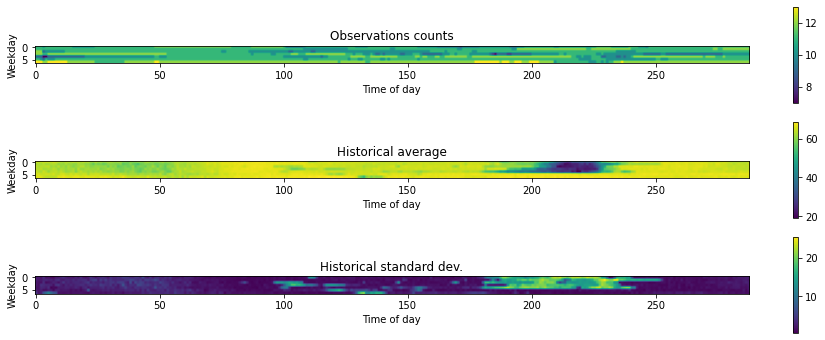

In [6]:
from matplotlib import pyplot as plt
loc = 0
fig, axs = plt.subplots(3, figsize=(16,6))
img = axs[0].imshow(counts[loc,:,:])
axs[0].set_title("Observations counts")
axs[0].set_xlabel("Time of day")
axs[0].set_ylabel("Weekday")
plt.colorbar(img, ax=axs[0])
img = axs[1].imshow(historical_avg[loc,:,:])
axs[1].set_title("Historical average")
axs[1].set_xlabel("Time of day")
axs[1].set_ylabel("Weekday")
plt.colorbar(img, ax=axs[1])
img = axs[2].imshow(historical_std[loc,:,:])
axs[2].set_title("Historical standard dev.")
axs[2].set_xlabel("Time of day")
axs[2].set_ylabel("Weekday")
plt.colorbar(img, ax=axs[2])
plt.show()

In [7]:
# compute residuals of historical averages
trues = []
preds = []
for dt in df.index:
    weekday = dt.weekday()
    if dt.date() in holidays:
        weekday = 6 # treat holidays as Sundays
    tod = int(dt.hour*12+dt.minute/5)
    preds.append(historical_avg[:,weekday,tod])
    trues.append(df.loc[dt].values)
    
trues = np.array(trues)[:,np.newaxis,:]
print(trues.shape)
preds = np.array(preds)[:,np.newaxis,:]
print(preds.shape)

evaluate_dcrnn(trues, preds)

(34272, 1, 207)
(34272, 1, 207)
Horizon 01, MAE: 3.83, MAPE: 0.1115, RMSE: 7.10


In [8]:
# 0 is the latest observed sample.
x_offsets = np.sort(
    # np.concatenate(([-week_size + 1, -day_size + 1], np.arange(-11, 1, 1)))
    np.concatenate((np.arange(-11, 1, 1),))
)
# Predict the next one hour
y_offsets = np.sort(np.arange(1, 13, 1))

# x: (num_samples, input_length, num_nodes, input_dim)
# y: (num_samples, output_length, num_nodes, output_dim)
x, y = generate_graph_seq2seq_io_data(
    df,
    x_offsets=x_offsets,
    y_offsets=y_offsets,
    add_time_in_day=False,
    add_day_in_week=False,
)
print("x shape: ", x.shape, ", y shape: ", y.shape)

df_ha = pd.DataFrame(preds[:,0,:], index=df.index, columns=df.columns)
x_ha, y_ha = generate_graph_seq2seq_io_data(
    df_ha,
    x_offsets=x_offsets,
    y_offsets=y_offsets,
    add_time_in_day=False,
    add_day_in_week=False,
)
print("x_ha shape: ", x_ha.shape, ", y_ha shape: ", y_ha.shape)

x shape:  (34249, 12, 207, 1) , y shape:  (34249, 12, 207, 1)
x_ha shape:  (34249, 12, 207, 1) , y_ha shape:  (34249, 12, 207, 1)


In [9]:
# train/val/test split
num_samples = x.shape[0]
num_test = round(num_samples * 0.2)
num_train = round(num_samples * 0.7)
num_val = num_samples - num_test - num_train

x_train, y_train = x[:num_train], y[:num_train]
x_val, y_val = (x[num_train: num_train + num_val], y[num_train: num_train + num_val])
x_test, y_test = x[-num_test:], y[-num_test:]
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

x_train_ha, y_train_ha = x_ha[:num_train], y_ha[:num_train]
x_val_ha, y_val_ha = (x_ha[num_train: num_train + num_val], y_ha[num_train: num_train + num_val])
x_test_ha, y_test_ha = x_ha[-num_test:], y_ha[-num_test:]
print(x_train_ha.shape, y_train_ha.shape)
print(x_val_ha.shape, y_val_ha.shape)
print(x_test_ha.shape, y_test_ha.shape)

# evaluate HA prediction on testset
evaluate_dcrnn(y_test[:,:,:,0], y_test_ha[:,:,:,0])

(23974, 12, 207, 1) (23974, 12, 207, 1)
(3425, 12, 207, 1) (3425, 12, 207, 1)
(6850, 12, 207, 1) (6850, 12, 207, 1)
(23974, 12, 207, 1) (23974, 12, 207, 1)
(3425, 12, 207, 1) (3425, 12, 207, 1)
(6850, 12, 207, 1) (6850, 12, 207, 1)
Horizon 01, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 02, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 03, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 04, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 05, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 06, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 07, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 08, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 09, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 10, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 11, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 12, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84


In [10]:
all_preds = []
all_trues = []
for loc in range(x.shape[2]):
    if not loc % 50:
        print(loc)
    
    loc_preds = []
    loc_trues = []
    for steps_ahead in range(12):
        # prepare input data
        x_tmp = x_train[:, :, loc, 0] - x_train_ha[:, :, loc, 0] # detrend input data for training
        x_tmp[np.where(x_tmp == -x_train_ha[:, :, loc, 0])] = 0 # impute missing values with HA (i.e. setting to zero)
        y_tmp = y_train[:, steps_ahead, loc, 0] - y_train_ha[:, steps_ahead, loc, 0] # detrend targets for training
        y_tmp[np.where(y_tmp == -y_train_ha[:, steps_ahead, loc, 0])] = 0 # impute missing values with HA
        
        # fit ML models
        reg = LinearRegression()
        reg.fit(x_tmp, y_tmp)
        
        # predict on test set
        trues = y_test[:, steps_ahead, loc, 0] # targets for test set (i.e., actual observations w/o detrending)
        x_test_tmp = x_test[:, :, loc, 0] - x_test_ha[:, :, loc, 0] # test input data
        x_test_tmp[np.where(x_test_tmp == -x_test_ha[:, :, loc, 0])] = 0 # impute missing values with HA
        preds = reg.predict(x_test_tmp) # make predictions on detrended inputs
        preds = preds + y_test_ha[:, steps_ahead, loc, 0] # convert preds back to original scale (revert detrending)

        loc_preds.append(preds)
        loc_trues.append(trues)

    all_preds.append(loc_preds)
    all_trues.append(loc_trues)

all_preds = np.array(all_preds).transpose([2,1,0])
print(all_preds.shape)
all_trues = np.array(all_trues).transpose([2,1,0])
print(all_trues.shape)

evaluate_dcrnn(all_trues, all_preds)

0
50
100
150
200
(6850, 12, 207)
(6850, 12, 207)
Horizon 01, MAE: 2.72, MAPE: 0.0666, RMSE: 4.37
Horizon 02, MAE: 3.06, MAPE: 0.0792, RMSE: 5.19
Horizon 03, MAE: 3.28, MAPE: 0.0878, RMSE: 5.71
Horizon 04, MAE: 3.44, MAPE: 0.0945, RMSE: 6.08
Horizon 05, MAE: 3.57, MAPE: 0.0998, RMSE: 6.37
Horizon 06, MAE: 3.68, MAPE: 0.1043, RMSE: 6.60
Horizon 07, MAE: 3.77, MAPE: 0.1080, RMSE: 6.78
Horizon 08, MAE: 3.84, MAPE: 0.1109, RMSE: 6.93
Horizon 09, MAE: 3.90, MAPE: 0.1134, RMSE: 7.05
Horizon 10, MAE: 3.95, MAPE: 0.1155, RMSE: 7.16
Horizon 11, MAE: 3.99, MAPE: 0.1173, RMSE: 7.25
Horizon 12, MAE: 4.02, MAPE: 0.1189, RMSE: 7.32


In [11]:
# sanity check by having an empty model that predicts always zero - this is the same as predicting using HA only

all_preds = []
all_trues = []
for loc in range(x.shape[2]):
    if not loc % 50:
        print(loc)
    
    loc_preds = []
    loc_trues = []
    for steps_ahead in range(12):
        # prepare input data
        x_tmp = x_train[:, :, loc, 0] - x_train_ha[:, :, loc, 0] # detrend input data for training
        x_tmp[np.where(x_tmp == -x_train_ha[:, :, loc, 0])] = 0 # impute missing values with HA (i.e. setting to zero)
        y_tmp = y_train[:, steps_ahead, loc, 0] - y_train_ha[:, steps_ahead, loc, 0] # detrend targets for training
        y_tmp[np.where(y_tmp == -y_train_ha[:, steps_ahead, loc, 0])] = 0 # impute missing values with HA
        
        # no ML model
        
        # predict on test set
        trues = y_test[:, steps_ahead, loc, 0] # targets for test set (i.e., actual observations w/o detrending)
        x_test_tmp = x_test[:, :, loc, 0] - x_test_ha[:, :, loc, 0] # test input data
        x_test_tmp[np.where(x_test_tmp == -x_test_ha[:, :, loc, 0])] = 0 # impute missing values with HA
        preds = 0 # prediction is always zero
        preds = preds + y_test_ha[:, steps_ahead, loc, 0] # convert preds back to original scale (revert detrending)

        loc_preds.append(preds)
        loc_trues.append(trues)

    all_preds.append(loc_preds)
    all_trues.append(loc_trues)

all_preds = np.array(all_preds).transpose([2,1,0])
print(all_preds.shape)
all_trues = np.array(all_trues).transpose([2,1,0])
print(all_trues.shape)

evaluate_dcrnn(all_trues, all_preds)

0
50
100
150
200
(6850, 12, 207)
(6850, 12, 207)
Horizon 01, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 02, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 03, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 04, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 05, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 06, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 07, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 08, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 09, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 10, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 11, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
Horizon 12, MAE: 4.19, MAPE: 0.1303, RMSE: 7.84
